In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.models import KeyedVectors
import re
from string import punctuation

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Bidirectional
from keras.layers import merge
from tensorflow.keras import layers, utils, callbacks, optimizers, regularizers
from tensorflow.keras.models import load_model
from tqdm import tqdm

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# train = pd.read_csv("../input/quora-question-pairs/train.csv.zip")
# test = pd.read_csv("../input/quora-question-pairs/test.csv")
data_set = pd.read_csv('/content/drive/MyDrive/MaLSTM/train.csv')

In [5]:
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
x_train, x_val, y_train,y_val = train_test_split(data_set[['question1', 'question2']], data_set[['is_duplicate']] , train_size=0.8)

In [6]:
data_set

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [7]:
train = x_train.join(y_train)
test = x_val.join(y_val)
train,test

(                                                question1  ... is_duplicate
 273779  How can I season steak? What spices should I use?  ...            1
 321969  Everytime I make out with my boyfriend, he cut...  ...            0
 142991             Which book shall I prefer for the CAT?  ...            1
 343029                           Topics for presentation?  ...            0
 62927   How many people die in a day on average worldw...  ...            1
 ...                                                   ...  ...          ...
 74017          What is the process to get a job at Wipro?  ...            0
 25236                  How can I become more interesting?  ...            1
 266501                     Is marrying your cousin wrong?  ...            1
 403524           How important is C++ in app development?  ...            0
 186170  What is the reason behind the sudden discontin...  ...            1
 
 [323432 rows x 3 columns],
                                              

In [8]:
train['question1']

273779    How can I season steak? What spices should I use?
321969    Everytime I make out with my boyfriend, he cut...
142991               Which book shall I prefer for the CAT?
343029                             Topics for presentation?
62927     How many people die in a day on average worldw...
                                ...                        
74017            What is the process to get a job at Wipro?
25236                    How can I become more interesting?
266501                       Is marrying your cousin wrong?
403524             How important is C++ in app development?
186170    What is the reason behind the sudden discontin...
Name: question1, Length: 323432, dtype: object

In [9]:
def clean_dataframe_train(train):
    stop_words = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']
    def text_to_wordlist(text, remove_stop_words=True, stem_words=False):
        text = re.sub(r"[^A-Za-z0-9]", " ", text)
        text = re.sub(r"what's", "", text)
        text = re.sub(r"What's", "", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"I'm", "I am", text)
        text = re.sub(r" m ", " am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"60k", " 60000 ", text)
        text = re.sub(r" e g ", " eg ", text)
        text = re.sub(r" b g ", " bg ", text)
        text = re.sub(r"\0s", "0", text)
        text = re.sub(r" 9 11 ", "911", text)
        text = re.sub(r"e-mail", "email", text)
        text = re.sub(r"\s{2,}", " ", text)
        text = re.sub(r"quikly", "quickly", text)
        text = re.sub(r" usa ", " America ", text)
        text = re.sub(r" USA ", " America ", text)
        text = re.sub(r" u s ", " America ", text)
        text = re.sub(r" uk ", " England ", text)
        text = re.sub(r" UK ", " England ", text)
        text = re.sub(r"india", "India", text)
        text = re.sub(r"switzerland", "Switzerland", text)
        text = re.sub(r"china", "China", text)
        text = re.sub(r"chinese", "Chinese", text) 
        text = re.sub(r"imrovement", "improvement", text)
        text = re.sub(r"intially", "initially", text)
        text = re.sub(r"quora", "Quora", text)
        text = re.sub(r" dms ", "direct messages ", text)  
        text = re.sub(r"demonitization", "demonetization", text) 
        text = re.sub(r"actived", "active", text)
        text = re.sub(r"kms", " kilometers ", text)
        text = re.sub(r"KMs", " kilometers ", text)
        text = re.sub(r" cs ", " computer science ", text) 
        text = re.sub(r" upvotes ", " up votes ", text)
        text = re.sub(r" iPhone ", " phone ", text)
        text = re.sub(r"\0rs ", " rs ", text) 
        text = re.sub(r"calender", "calendar", text)
        text = re.sub(r"ios", "operating system", text)
        text = re.sub(r"gps", "GPS", text)
        text = re.sub(r"gst", "GST", text)
        text = re.sub(r"programing", "programming", text)
        text = re.sub(r"bestfriend", "best friend", text)
        text = re.sub(r"dna", "DNA", text)
        text = re.sub(r"III", "3", text) 
        text = re.sub(r"the US", "America", text)
        text = re.sub(r"Astrology", "astrology", text)
        text = re.sub(r"Method", "method", text)
        text = re.sub(r"Find", "find", text) 
        text = re.sub(r"banglore", "Banglore", text)
        text = re.sub(r" J K ", " JK ", text)

        text = ''.join([c for c in text if c not in punctuation])

        if remove_stop_words:
            text = text.split()
            text = [w for w in text if not w in stop_words]
            text = " ".join(text)

        if stem_words:
            text = text.split()
            stemmer = SnowballStemmer('english')
            stemmed_words = [stemmer.stem(word) for word in text]
            text = " ".join(stemmed_words)

        return(text)
    
    def process_questions(question_list, questions, question_list_name, dataframe):
        for question in questions:
            question_list.append(text_to_wordlist(str(question)))
            if len(question_list) % 100000 == 0:
                progress = len(question_list)/len(dataframe) * 100
                print("{} is {}% complete.".format(question_list_name, round(progress, 1)))
            
    
    train_question1 = []
    process_questions(train_question1, train.question1, 'train_question1', train)

    train_question2 = []
    process_questions(train_question2, train.question2, 'train_question2', train)

    train["question1"] = train_question1
    train["question2"] = train_question2
    
    return train

In [10]:
def clean_dataframe_test(test):
    stop_words = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']
    def text_to_wordlist(text, remove_stop_words=True, stem_words=False):
        text = re.sub(r"[^A-Za-z0-9]", " ", text)
        text = re.sub(r"what's", "", text)
        text = re.sub(r"What's", "", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"I'm", "I am", text)
        text = re.sub(r" m ", " am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"60k", " 60000 ", text)
        text = re.sub(r" e g ", " eg ", text)
        text = re.sub(r" b g ", " bg ", text)
        text = re.sub(r"\0s", "0", text)
        text = re.sub(r" 9 11 ", "911", text)
        text = re.sub(r"e-mail", "email", text)
        text = re.sub(r"\s{2,}", " ", text)
        text = re.sub(r"quikly", "quickly", text)
        text = re.sub(r" usa ", " America ", text)
        text = re.sub(r" USA ", " America ", text)
        text = re.sub(r" u s ", " America ", text)
        text = re.sub(r" uk ", " England ", text)
        text = re.sub(r" UK ", " England ", text)
        text = re.sub(r"india", "India", text)
        text = re.sub(r"switzerland", "Switzerland", text)
        text = re.sub(r"china", "China", text)
        text = re.sub(r"chinese", "Chinese", text) 
        text = re.sub(r"imrovement", "improvement", text)
        text = re.sub(r"intially", "initially", text)
        text = re.sub(r"quora", "Quora", text)
        text = re.sub(r" dms ", "direct messages ", text)  
        text = re.sub(r"demonitization", "demonetization", text) 
        text = re.sub(r"actived", "active", text)
        text = re.sub(r"kms", " kilometers ", text)
        text = re.sub(r"KMs", " kilometers ", text)
        text = re.sub(r" cs ", " computer science ", text) 
        text = re.sub(r" upvotes ", " up votes ", text)
        text = re.sub(r" iPhone ", " phone ", text)
        text = re.sub(r"\0rs ", " rs ", text) 
        text = re.sub(r"calender", "calendar", text)
        text = re.sub(r"ios", "operating system", text)
        text = re.sub(r"gps", "GPS", text)
        text = re.sub(r"gst", "GST", text)
        text = re.sub(r"programing", "programming", text)
        text = re.sub(r"bestfriend", "best friend", text)
        text = re.sub(r"dna", "DNA", text)
        text = re.sub(r"III", "3", text) 
        text = re.sub(r"the US", "America", text)
        text = re.sub(r"Astrology", "astrology", text)
        text = re.sub(r"Method", "method", text)
        text = re.sub(r"Find", "find", text) 
        text = re.sub(r"banglore", "Banglore", text)
        text = re.sub(r" J K ", " JK ", text)

        text = ''.join([c for c in text if c not in punctuation])

        if remove_stop_words:
            text = text.split()
            text = [w for w in text if not w in stop_words]
            text = " ".join(text)

        if stem_words:
            text = text.split()
            stemmer = SnowballStemmer('english')
            stemmed_words = [stemmer.stem(word) for word in text]
            text = " ".join(stemmed_words)

        return(text)
    
    def process_questions(question_list, questions, question_list_name, dataframe):
        for question in questions:
            question_list.append(text_to_wordlist(str(question)))
            if len(question_list) % 100000 == 0:
                progress = len(question_list)/len(dataframe) * 100
                print("{} is {}% complete.".format(question_list_name, round(progress, 1)))
            
    
    test_question1 = []
    process_questions(test_question1, test.question1, 'test_question1', test)

    test_question2 = []
    process_questions(test_question2, test.question2, 'test_question2', test)

    test["question1"] = test_question1
    test["question2"] = test_question2
    
    return test

In [11]:
train = clean_dataframe_train(train)
test = clean_dataframe_test(test)

train_question1 is 30.9% complete.
train_question1 is 61.8% complete.
train_question1 is 92.8% complete.
train_question2 is 30.9% complete.
train_question2 is 61.8% complete.
train_question2 is 92.8% complete.


In [12]:
train,test

(                                                question1  ... is_duplicate
 273779         How can I season steak spices should I use  ...            1
 321969  Everytime I make out with my boyfriend he cuts...  ...            0
 142991                            book shall I prefer CAT  ...            1
 343029                                Topics presentation  ...            0
 62927     How many people die in day on average worldwide  ...            1
 ...                                                   ...  ...          ...
 74017                            process get job at Wipro  ...            0
 25236                   How can I become more interesting  ...            1
 266501                         marrying your cousin wrong  ...            1
 403524                 How important C in app development  ...            0
 186170  reason behind sudden discontinuance 500 1000 n...  ...            1
 
 [323432 rows x 3 columns],
                                              

In [13]:
MAX_SEQUENCE_LENGTH = 20
EMBEDDING_DIM = 300

In [14]:
corpus = []

feats = ['question1','question2']
for f in feats:
    train[f] = train[f].astype(str)
    test[f] = test[f].astype(str)
    corpus+=train[f].values.tolist()
    
    
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
X_q1 = tokenizer.texts_to_sequences(train['question1'])
X_q2 = tokenizer.texts_to_sequences(train['question2'])

X_test_q1 = tokenizer.texts_to_sequences(test['question1'])
X_test_q2 = tokenizer.texts_to_sequences(test['question2'])


X_q1 = pad_sequences(X_q1, maxlen=MAX_SEQUENCE_LENGTH)
X_q2 = pad_sequences(X_q2, maxlen=MAX_SEQUENCE_LENGTH)
X_test_q1 = pad_sequences(X_test_q1, maxlen=MAX_SEQUENCE_LENGTH)
X_test_q2 = pad_sequences(X_test_q2, maxlen=MAX_SEQUENCE_LENGTH)

y = train['is_duplicate'].values

word_index = tokenizer.word_index
nb_words = len(word_index)+1

In [15]:
print(train['question1'])

273779           How can I season steak spices should I use
321969    Everytime I make out with my boyfriend he cuts...
142991                              book shall I prefer CAT
343029                                  Topics presentation
62927       How many people die in day on average worldwide
                                ...                        
74017                              process get job at Wipro
25236                     How can I become more interesting
266501                           marrying your cousin wrong
403524                   How important C in app development
186170    reason behind sudden discontinuance 500 1000 n...
Name: question1, Length: 323432, dtype: object


In [16]:
!ls -al
!mkdir .vector_cache
!cp /content/drive/MyDrive/MaLSTM/.vector_cache/glove.840B.300d.zip .vector_cache/glove.840B.300d.zip

total 20
drwxr-xr-x 1 root root 4096 Nov 24 05:54 .
drwxr-xr-x 1 root root 4096 Nov 24 05:53 ..
drwxr-xr-x 4 root root 4096 Nov 18 14:35 .config
drwx------ 5 root root 4096 Nov 24 05:54 drive
drwxr-xr-x 1 root root 4096 Nov 18 14:36 sample_data
^C


In [17]:
!ls .vector_cache

In [16]:
import torchtext.vocab as vocab
glove = vocab.GloVe(name='840B', dim=300)

.vector_cache/glove.840B.300d.zip: 2.18GB [07:00, 5.18MB/s]                            
100%|█████████▉| 2196016/2196017 [04:52<00:00, 7496.73it/s]


In [17]:
glove['apple']

tensor([-3.6391e-01,  4.3771e-01, -2.0447e-01, -2.2889e-01, -1.4227e-01,
         2.7396e-01, -1.1435e-02, -1.8578e-01,  3.7361e-01,  7.5339e-01,
        -3.0591e-01,  2.3741e-02, -7.7876e-01, -1.3802e-01,  6.6992e-02,
        -6.4303e-02, -4.0024e-01,  1.5309e+00, -1.3897e-02, -1.5657e-01,
         2.5366e-01,  2.1610e-01, -3.2720e-01,  3.4974e-01, -6.4845e-02,
        -2.9501e-01, -6.3923e-01, -6.2017e-02,  2.4559e-01, -6.9334e-02,
        -3.9967e-01,  3.0925e-02,  4.9033e-01,  6.7524e-01,  1.9481e-01,
         5.1488e-01, -3.1149e-01, -7.9939e-02, -6.2096e-01, -5.3277e-03,
        -1.1264e-01,  8.3528e-02, -7.6947e-03, -1.0788e-01,  1.6628e-01,
         4.2273e-01, -1.9009e-01, -2.9035e-01,  4.5630e-02,  1.0120e-01,
        -4.0855e-01, -3.5000e-01, -3.6175e-01, -4.1396e-01,  5.9485e-01,
        -1.1524e+00,  3.2424e-02,  3.4364e-01, -1.9209e-01,  4.3255e-02,
         4.9227e-02, -5.4258e-01,  9.1275e-01,  2.9576e-01,  2.3658e-02,
        -6.8737e-01, -1.9503e-01, -1.1059e-01, -2.2

In [18]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))

# def load_google_word_embeddings(path):
#     return KeyedVectors.load_word2vec_format('/content/drive/MyDrive/MaLSTM/GoogleNews-vectors-negative300.bin.gz', binary=True) 

def build_matrix(word_index, path):
    # embedding_index = load_google_word_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = glove[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

glove_path = 'glove.840B.300d.txt'
embedding_matrix,unknown_words = build_matrix(word_index,glove_path)

In [19]:
embedding_matrix.shape

(77675, 300)

In [20]:
# from sklearn.metrics import log_loss
# from sklearn.model_selection import train_test_split
# X_train_q1,X_val_q1,X_train_q2,X_val_q2,y_train,y_val = train_test_split(X_q1,X_q2,y,train_size=0.8,random_state=1024)
# print(X_train_q1.shape,X_val_q1.shape)
# X_train = [X_train_q1,X_train_q2]
# X_val = [X_val_q1,X_val_q2]
# X_test = [X_test_q1,X_test_q2]

In [21]:
from sklearn.metrics import log_loss
X_train = [X_q1, X_q2]
X_val = [X_test_q1, X_test_q2]
y_val = test['is_duplicate'].values

In [22]:
print(X_q1.shape, X_q2.shape,train.shape, X_test_q1.shape)
y.shape,y_val.shape

(323432, 20) (323432, 20) (323432, 3) (80858, 20)


((323432,), (80858,))

In [23]:
def exponent_neg_manhattan_distance(left, right):
    ''' 
    Purpose : Helper function for the similarity estimate of the LSTMs outputs
    Inputs : Two n-dimensional vectors
    Output : Manhattan distance between the input vectors
    
    '''
    import keras.backend as K
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 300)      23302500    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 128)          219648      ['embedding[0][0]',          

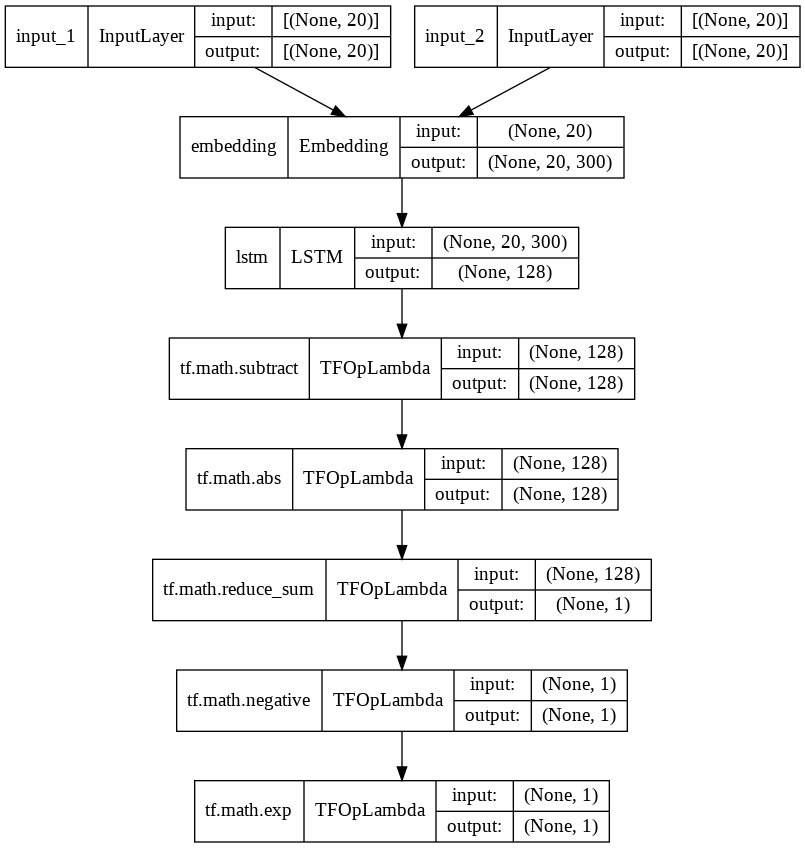

In [24]:
input_q1 = Input(shape = X_train[0].shape[1])
input_q2 = Input(shape = X_train[0].shape[1])

embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            input_length = X_train[0].shape[1],
                            weights = [embedding_matrix],
                            trainable=False)


embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

bilstm_layer = LSTM(128)

x1 = bilstm_layer(embedded_sequences_q1)
x2 = bilstm_layer(embedded_sequences_q2)

distance = exponent_neg_manhattan_distance(x1, x2)
# x = Dense(64, activation="relu")(distance)

model = Model(inputs=[input_q1, input_q2], outputs=distance)
model.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["accuracy"])



model.summary()
utils.plot_model(model, show_shapes=True, expand_nested=True)

In [25]:
es = callbacks.EarlyStopping(
    monitor='val_loss', patience=3
)
checkpoint = callbacks.ModelCheckpoint('malstm.h5', save_best_only=True, save_weights_only=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=2048, 
    epochs=32,
    callbacks=[es,checkpoint]
)

Epoch 1/32
158/158 [==============================] - 24s 102ms/step - loss: 0.2132 - accuracy: 0.7124 - val_loss: 0.1668 - val_accuracy: 0.7551
Epoch 2/32
158/158 [==============================] - 15s 94ms/step - loss: 0.1563 - accuracy: 0.7752 - val_loss: 0.1530 - val_accuracy: 0.7815
Epoch 3/32
158/158 [==============================] - 15s 94ms/step - loss: 0.1470 - accuracy: 0.7930 - val_loss: 0.1477 - val_accuracy: 0.7929
Epoch 4/32
158/158 [==============================] - 15s 95ms/step - loss: 0.1421 - accuracy: 0.8023 - val_loss: 0.1441 - val_accuracy: 0.7972
Epoch 5/32
158/158 [==============================] - 15s 94ms/step - loss: 0.1387 - accuracy: 0.8083 - val_loss: 0.1418 - val_accuracy: 0.8023
Epoch 6/32
158/158 [==============================] - 15s 95ms/step - loss: 0.1360 - accuracy: 0.8129 - val_loss: 0.1395 - val_accuracy: 0.8038
Epoch 7/32
158/158 [==============================] - 15s 95ms/step - loss: 0.1335 - accuracy: 0.8165 - val_loss: 0.1382 - val_accuracy

In [26]:
model.save('/content/drive/MyDrive/MaLSTM/malstm.h5')

In [65]:
modeL = load_model('/content/drive/MyDrive/MaLSTM/malstm.h5')
y_predict = modeL.predict(X_val)
y_predict = y_predict.reshape(y_val.shape)
y_predict[y_predict >= 0.5] = 1
y_predict[y_predict < 0.5] = 0
y_predict

array([0., 0., 1., ..., 1., 0., 0.], dtype=float32)

In [66]:
y_val = np.array(y_val)
y_val

array([0, 1, 1, ..., 1, 0, 0])

In [68]:
y_predict[y_predict == y_val].shape[0] / y_predict.shape[0]

0.8310989636152267